In [32]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [33]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [34]:
import impl.layer as l
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.grads = []
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), 
                 b=np.zeros((1, H)))
        self.model.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), 
                     b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), 
                 b=np.zeros((1, C)))
        self.model.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        dX = dout @ W.T # VBP

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
        X = y.copy() # pass to the next layer
        if train:
            caches.append((fc_cache, nl_cache))
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches # for backpropating the error

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train] + l.eps) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches, y):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward is included in dcross_entropy.
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        dy = dX.copy()
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            grads = self.train_backward(dy, caches, y_prob)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
            #             print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
            #             format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [35]:
# Hyper-parameters
n_iter = 5000 # number of epochs
alpha = 1e-2 # learning_rate
mb_size = 100 # minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10, train loss-2.2383, acc-0.2300, valid loss-2.2657, acc-0.1696, test loss-2.2644, acc-0.1708
Iter-20, train loss-2.2434, acc-0.2400, valid loss-2.2388, acc-0.2356, test loss-2.2373, acc-0.2411
Iter-30, train loss-2.2180, acc-0.2800, valid loss-2.2121, acc-0.3100, test loss-2.2103, acc-0.3161
Iter-40, train loss-2.1881, acc-0.4200, valid loss-2.1841, acc-0.3760, test loss-2.1821, acc-0.3811
Iter-50, train loss-2.1686, acc-0.3700, valid loss-2.1579, acc-0.4120, test loss-2.1556, acc-0.4158
Iter-60, train loss-2.1401, acc-0.4000, valid loss-2.1310, acc-0.4368, test loss-2.1286, acc-0.4449
Iter-70, train loss-2.0914, acc-0.5100, valid loss-2.1053, acc-0.4644, test loss-2.1027, acc-0.4688
Iter-80, train loss-2.0525, acc-0.5300, valid loss-2.0775, acc-0.4826, test loss-2.0746, acc-0.4861
Iter-90, train loss-2.0402, acc-0.4800, valid loss-2.0494, acc-0.4980, test loss-2.0464, acc-0.5024
Iter-100, train loss-2.0130, acc-0.5500, valid loss-2.0225, acc-0.5140, test loss-2.0194, acc-0.5200

Iter-830, train loss-0.7080, acc-0.8600, valid loss-0.7537, acc-0.8412, test loss-0.7668, acc-0.8319
Iter-840, train loss-0.7542, acc-0.8400, valid loss-0.7468, acc-0.8422, test loss-0.7605, acc-0.8331
Iter-850, train loss-0.6882, acc-0.8200, valid loss-0.7403, acc-0.8440, test loss-0.7542, acc-0.8333
Iter-860, train loss-0.6522, acc-0.8900, valid loss-0.7340, acc-0.8448, test loss-0.7480, acc-0.8349
Iter-870, train loss-0.7034, acc-0.8600, valid loss-0.7285, acc-0.8464, test loss-0.7419, acc-0.8356
Iter-880, train loss-0.7364, acc-0.8500, valid loss-0.7222, acc-0.8460, test loss-0.7355, acc-0.8371
Iter-890, train loss-0.8321, acc-0.7700, valid loss-0.7162, acc-0.8478, test loss-0.7297, acc-0.8369
Iter-900, train loss-0.6840, acc-0.8500, valid loss-0.7104, acc-0.8480, test loss-0.7237, acc-0.8388
Iter-910, train loss-0.6146, acc-0.8700, valid loss-0.7045, acc-0.8490, test loss-0.7177, acc-0.8397
Iter-920, train loss-0.7421, acc-0.7800, valid loss-0.6989, acc-0.8492, test loss-0.7119, a

Iter-1640, train loss-0.3984, acc-0.9300, valid loss-0.4754, acc-0.8834, test loss-0.4877, acc-0.8772
Iter-1650, train loss-0.5143, acc-0.8800, valid loss-0.4733, acc-0.8842, test loss-0.4861, acc-0.8760
Iter-1660, train loss-0.4441, acc-0.8700, valid loss-0.4720, acc-0.8850, test loss-0.4847, acc-0.8773
Iter-1670, train loss-0.4181, acc-0.9200, valid loss-0.4703, acc-0.8856, test loss-0.4829, acc-0.8773
Iter-1680, train loss-0.3916, acc-0.9200, valid loss-0.4685, acc-0.8860, test loss-0.4812, acc-0.8776
Iter-1690, train loss-0.5326, acc-0.9000, valid loss-0.4672, acc-0.8844, test loss-0.4794, acc-0.8781
Iter-1700, train loss-0.5300, acc-0.8400, valid loss-0.4655, acc-0.8854, test loss-0.4779, acc-0.8790
Iter-1710, train loss-0.6238, acc-0.8300, valid loss-0.4640, acc-0.8850, test loss-0.4762, acc-0.8788
Iter-1720, train loss-0.5380, acc-0.8600, valid loss-0.4625, acc-0.8846, test loss-0.4749, acc-0.8795
Iter-1730, train loss-0.5249, acc-0.8400, valid loss-0.4607, acc-0.8846, test loss

Iter-2450, train loss-0.3673, acc-0.9300, valid loss-0.3885, acc-0.8964, test loss-0.3991, acc-0.8958
Iter-2460, train loss-0.4703, acc-0.8800, valid loss-0.3879, acc-0.8974, test loss-0.3987, acc-0.8960
Iter-2470, train loss-0.5147, acc-0.8000, valid loss-0.3876, acc-0.8972, test loss-0.3977, acc-0.8966
Iter-2480, train loss-0.4257, acc-0.8900, valid loss-0.3868, acc-0.8966, test loss-0.3971, acc-0.8973
Iter-2490, train loss-0.4531, acc-0.8800, valid loss-0.3856, acc-0.8968, test loss-0.3963, acc-0.8968
Iter-2500, train loss-0.4953, acc-0.8700, valid loss-0.3845, acc-0.8970, test loss-0.3957, acc-0.8967
Iter-2510, train loss-0.4681, acc-0.8700, valid loss-0.3839, acc-0.8980, test loss-0.3951, acc-0.8969
Iter-2520, train loss-0.4991, acc-0.8700, valid loss-0.3828, acc-0.8982, test loss-0.3943, acc-0.8967
Iter-2530, train loss-0.4210, acc-0.8700, valid loss-0.3823, acc-0.8988, test loss-0.3935, acc-0.8966
Iter-2540, train loss-0.2510, acc-0.9500, valid loss-0.3818, acc-0.8984, test loss

Iter-3260, train loss-0.4636, acc-0.8800, valid loss-0.3421, acc-0.9062, test loss-0.3554, acc-0.9036
Iter-3270, train loss-0.4076, acc-0.8900, valid loss-0.3422, acc-0.9056, test loss-0.3550, acc-0.9038
Iter-3280, train loss-0.3851, acc-0.9000, valid loss-0.3416, acc-0.9058, test loss-0.3546, acc-0.9042
Iter-3290, train loss-0.3357, acc-0.9200, valid loss-0.3415, acc-0.9060, test loss-0.3541, acc-0.9043
Iter-3300, train loss-0.5658, acc-0.8300, valid loss-0.3405, acc-0.9060, test loss-0.3534, acc-0.9048
Iter-3310, train loss-0.4388, acc-0.9300, valid loss-0.3403, acc-0.9060, test loss-0.3531, acc-0.9048
Iter-3320, train loss-0.3354, acc-0.9100, valid loss-0.3399, acc-0.9064, test loss-0.3526, acc-0.9045
Iter-3330, train loss-0.2226, acc-0.9500, valid loss-0.3395, acc-0.9066, test loss-0.3518, acc-0.9049
Iter-3340, train loss-0.2881, acc-0.9300, valid loss-0.3392, acc-0.9058, test loss-0.3512, acc-0.9049
Iter-3350, train loss-0.2247, acc-0.9300, valid loss-0.3386, acc-0.9062, test loss

Iter-4070, train loss-0.2751, acc-0.9500, valid loss-0.3118, acc-0.9134, test loss-0.3264, acc-0.9084
Iter-4080, train loss-0.3460, acc-0.8700, valid loss-0.3117, acc-0.9130, test loss-0.3262, acc-0.9081
Iter-4090, train loss-0.3268, acc-0.9400, valid loss-0.3115, acc-0.9136, test loss-0.3258, acc-0.9083
Iter-4100, train loss-0.3712, acc-0.9000, valid loss-0.3116, acc-0.9124, test loss-0.3250, acc-0.9084
Iter-4110, train loss-0.4051, acc-0.9100, valid loss-0.3112, acc-0.9134, test loss-0.3247, acc-0.9085
Iter-4120, train loss-0.3223, acc-0.8800, valid loss-0.3113, acc-0.9126, test loss-0.3245, acc-0.9078
Iter-4130, train loss-0.2753, acc-0.9300, valid loss-0.3113, acc-0.9126, test loss-0.3245, acc-0.9086
Iter-4140, train loss-0.2065, acc-0.9700, valid loss-0.3107, acc-0.9126, test loss-0.3244, acc-0.9087
Iter-4150, train loss-0.3287, acc-0.8900, valid loss-0.3106, acc-0.9126, test loss-0.3241, acc-0.9095
Iter-4160, train loss-0.2931, acc-0.8900, valid loss-0.3101, acc-0.9136, test loss

Iter-4880, train loss-0.3254, acc-0.9100, valid loss-0.2915, acc-0.9184, test loss-0.3055, acc-0.9143
Iter-4890, train loss-0.3014, acc-0.9300, valid loss-0.2912, acc-0.9180, test loss-0.3051, acc-0.9137
Iter-4900, train loss-0.1952, acc-0.9300, valid loss-0.2908, acc-0.9178, test loss-0.3047, acc-0.9144
Iter-4910, train loss-0.3366, acc-0.9100, valid loss-0.2909, acc-0.9172, test loss-0.3042, acc-0.9144
Iter-4920, train loss-0.4117, acc-0.8900, valid loss-0.2907, acc-0.9178, test loss-0.3041, acc-0.9147
Iter-4930, train loss-0.3533, acc-0.8700, valid loss-0.2902, acc-0.9186, test loss-0.3040, acc-0.9146
Iter-4940, train loss-0.3266, acc-0.9000, valid loss-0.2898, acc-0.9190, test loss-0.3041, acc-0.9146
Iter-4950, train loss-0.3384, acc-0.9100, valid loss-0.2899, acc-0.9178, test loss-0.3037, acc-0.9152
Iter-4960, train loss-0.1811, acc-0.9700, valid loss-0.2891, acc-0.9182, test loss-0.3031, acc-0.9148
Iter-4970, train loss-0.3343, acc-0.9000, valid loss-0.2891, acc-0.9180, test loss

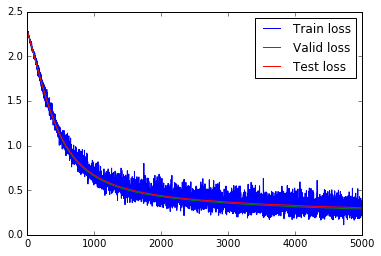

In [36]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

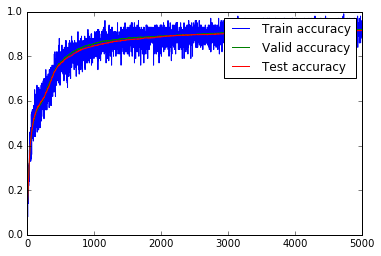

In [37]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()